In [2]:
# %% [bootstrap deps] —— 在当前 Notebook 内核中自动补齐依赖
import sys, subprocess, importlib

REQ = {
    "joblib": "joblib==1.4.2",
    "yaml": "pyyaml==6.0.2",
    "pyarrow": "pyarrow==16.1.0",
    "openpyxl": "openpyxl==3.1.5"
}

def ensure(import_name: str, pip_spec: str):
    try:
        importlib.import_module(import_name)
        print(f"[ok] {import_name} already available")
        return
    except Exception:
        pass
    print(f"[setup] installing {pip_spec} ...")
    r = subprocess.run([sys.executable, "-m", "pip", "install", pip_spec, "-q", "--disable-pip-version-check", "--no-input"], capture_output=True, text=True)
    if r.returncode != 0:
        print("".join(r.stderr.splitlines()[-10:]))
        raise RuntimeError(f"pip install failed: {pip_spec}")
    importlib.invalidate_caches()
    importlib.import_module(import_name)
    print(f"[ok] {import_name} ready")

for imp, spec in REQ.items():
    ensure(imp, spec)
print("[done] dependency bootstrap complete.")

[ok] joblib already available
[ok] yaml already available
[ok] pyarrow already available
[ok] openpyxl already available
[done] dependency bootstrap complete.


# 03 · 建模与结果汇总（ICU Lymphoma ML）

> 本 Notebook 汇总 `src.train / src.evaluate / src.threshold_scan` 的输出，并可在此快速复跑上述步骤。

In [3]:
# %% [imports & paths]
from pathlib import Path
import json, warnings, subprocess, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

PROJECT_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
CONF_PATH = PROJECT_ROOT / "conf" / "config.yaml"
with open(CONF_PATH, "r", encoding="utf-8") as f: CFG = yaml.safe_load(f)

OUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
MODEL_DIR = OUT_DIR / "models"
ARTI_DIR = OUT_DIR / "artifacts"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)
MODEL = "random_forest"  # 可按需修改
CAL_METHOD = "isotonic"  # 或 "none"/"raw"

print("[paths]",
      "  project:", PROJECT_ROOT,
      "  outputs:", OUT_DIR,
      "  model  :", MODEL,
      "  method :", CAL_METHOD)

# 统一风格
def _fallback_mpl_style():
    plt.rcParams.update({
        "figure.dpi": 120, "savefig.dpi": 300,
        "axes.titlesize": 12, "axes.labelsize": 11,
        "xtick.labelsize": 10, "ytick.labelsize": 10,
        "legend.fontsize": 10, "lines.linewidth": 1.8,
        "axes.grid": True, "grid.alpha": 0.2
    })
try:
    from src.data_utils import apply_mpl_style
    apply_mpl_style()
    print("[style] using src.data_utils.apply_mpl_style")
except Exception:
    _fallback_mpl_style()
    print("[style] using fallback mpl style")

[paths]   project: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro   outputs: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs   model  : random_forest   method : isotonic
[style] using fallback mpl style


## 1. 可选：一键复跑训练/评估/阈值扫描
- 建议按顺序：`train → evaluate → threshold_scan`
- 运行时间与数据规模/CPU有关；若此前已完成，可跳过。

In [4]:
# %% [optional run] —— 设置 True 以复跑
RUN_TRAIN = False
RUN_EVAL = False
RUN_THRSCAN = False

if RUN_TRAIN:
    print("[run] python -m src.train --config conf/config.yaml --model", MODEL)
    r = subprocess.run([sys.executable, "-m", "src.train", "--config", str(CONF_PATH), "--model", MODEL], capture_output=True, text=True)
    print(r.stdout)
    if r.returncode != 0: print(r.stderr); raise RuntimeError("train failed")

if RUN_EVAL:
    print("[run] python -m src.evaluate --config conf/config.yaml --model", MODEL)
    r = subprocess.run([sys.executable, "-m", "src.evaluate", "--config", str(CONF_PATH), "--model", MODEL], capture_output=True, text=True)
    print(r.stdout)
    if r.returncode != 0: print(r.stderr); raise RuntimeError("evaluate failed")

if RUN_THRSCAN:
    print("[run] python -m src.threshold_scan --config conf/config.yaml --model", MODEL, "--method", CAL_METHOD)
    r = subprocess.run([sys.executable, "-m", "src.threshold_scan", "--config", str(CONF_PATH), "--model", MODEL, "--method", CAL_METHOD], capture_output=True, text=True)
    print(r.stdout)
    if r.returncode != 0: print(r.stderr); raise RuntimeError("threshold_scan failed")

## 2. 读取主指标表与 AUC 表
- `outputs/metrics_test_{model}.csv`
- `outputs/metrics_test.csv`（可能包含多模型汇总）
- `outputs/model_auc_test.csv`（每个 m 的 AUC）

In [5]:
# %% [load metrics] 
from IPython.display import display, Image

fp_model_metrics = TAB_DIR / f"metrics_test_{MODEL}.csv"
fp_all_metrics   = TAB_DIR / "metrics_test.csv"
fp_auc_table     = TAB_DIR / "model_auc_test.csv"

df_model = pd.read_csv(fp_model_metrics) if fp_model_metrics.exists() else None
df_all   = pd.read_csv(fp_all_metrics) if fp_all_metrics.exists() else None
df_auc   = pd.read_csv(fp_auc_table) if fp_auc_table.exists() else None

if df_model is not None:
    print("[ok] metrics (model)")
    display(df_model)
else:
    warnings.warn(f"缺少 {fp_model_metrics}")

if df_all is not None:
    print("[ok] metrics (all)")
    display(df_all)
else:
    warnings.warn(f"缺少 {fp_all_metrics}")

if df_auc is not None:
    print("[ok] AUC by m")
    display(df_auc)
else:
    warnings.warn(f"缺少 {fp_auc_table}")

[ok] metrics (model)


,model,method,n_test,prevalence,roc_auc,roc_auc_lo,roc_auc_hi,ap,ap_lo,ap_hi,brier,accuracy,f1,precision,recall
0,random_forest,raw,478,0.215481,0.750511,0.697902,0.801734,0.439239,0.357857,0.553545,0.14716,0.797071,0.312057,0.578947,0.213592


[ok] metrics (all)


,model,method,n_test,prevalence,roc_auc,roc_auc_lo,roc_auc_hi,ap,ap_lo,ap_hi,brier,accuracy,f1,precision,recall
0,random_forest,raw,478,0.215481,0.750511,0.697902,0.801734,0.439239,0.357857,0.553545,0.14716,0.797071,0.312057,0.578947,0.213592
1,random_forest,isotonic,478,0.215481,0.750511,0.697902,0.801734,0.439239,0.357857,0.553545,0.14716,0.797071,0.312057,0.578947,0.213592


[ok] AUC by m


,model,method,roc_auc,ap
0,random_forest,raw,0.750511,0.439239
1,random_forest,isotonic,0.750511,0.439239


## 3. 展示 ROC / PR / Calibration 图
自动寻找 `outputs/figures/` 下与当前模型匹配的图像，如存在 `*_isotonic` 优先展示。

[fig] ROC: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/roc_test_random_forest_isotonic.png


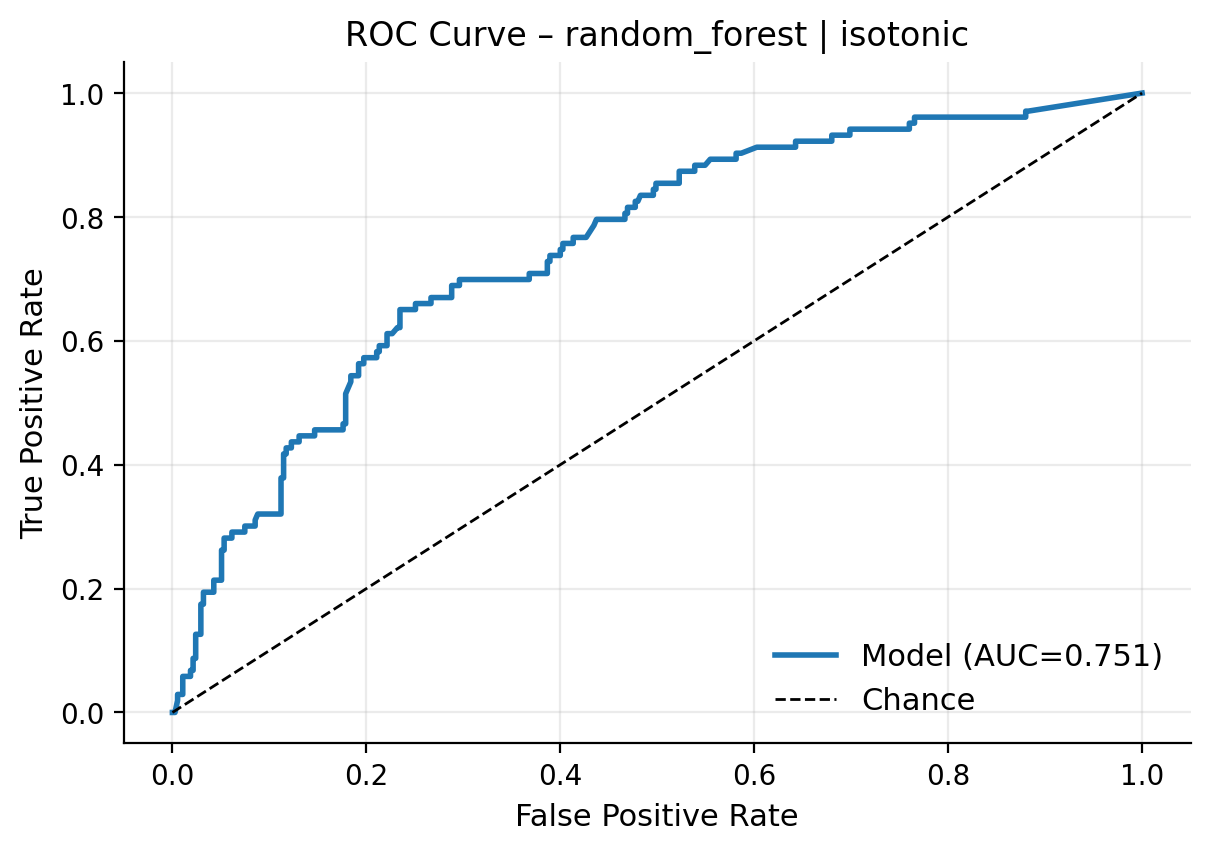

[fig] PR: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/pr_test_random_forest_isotonic.png


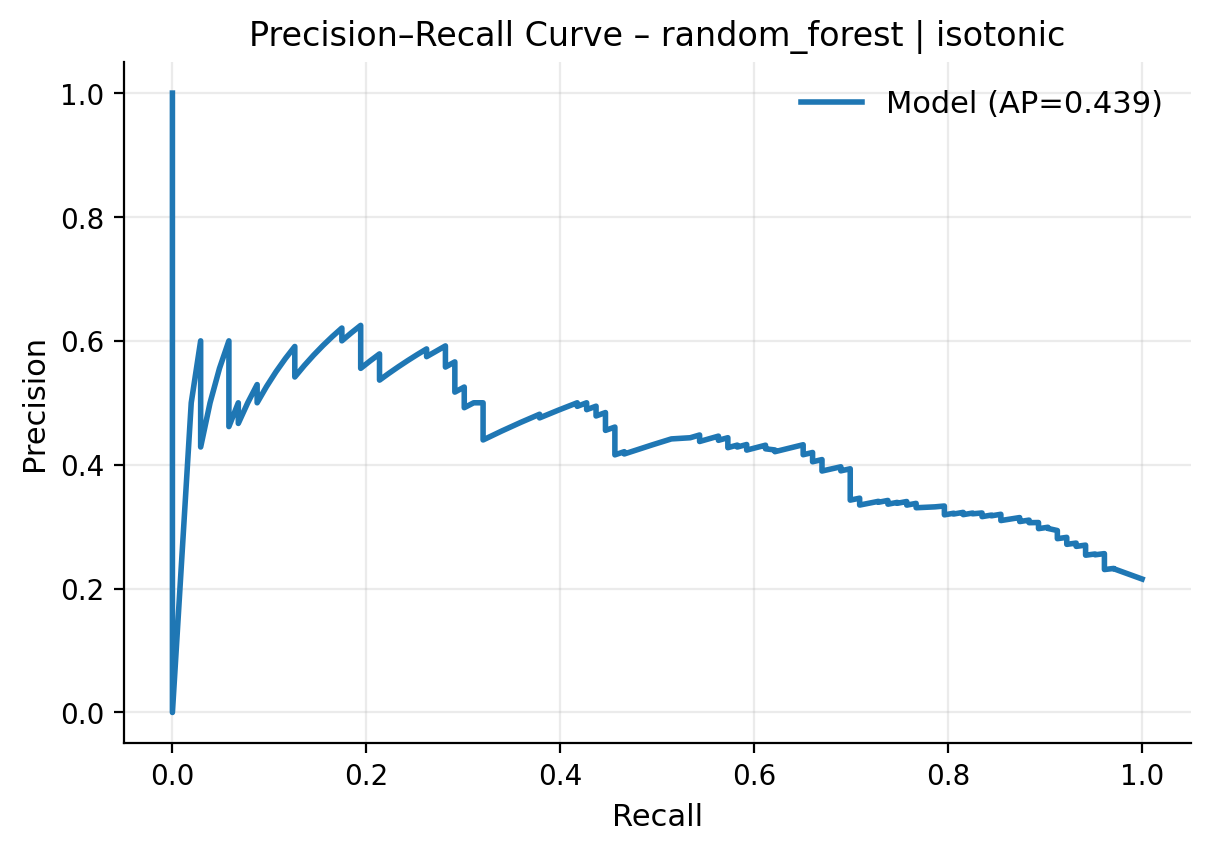

[fig] Calibration: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/calibration_test_random_forest_isotonic.png


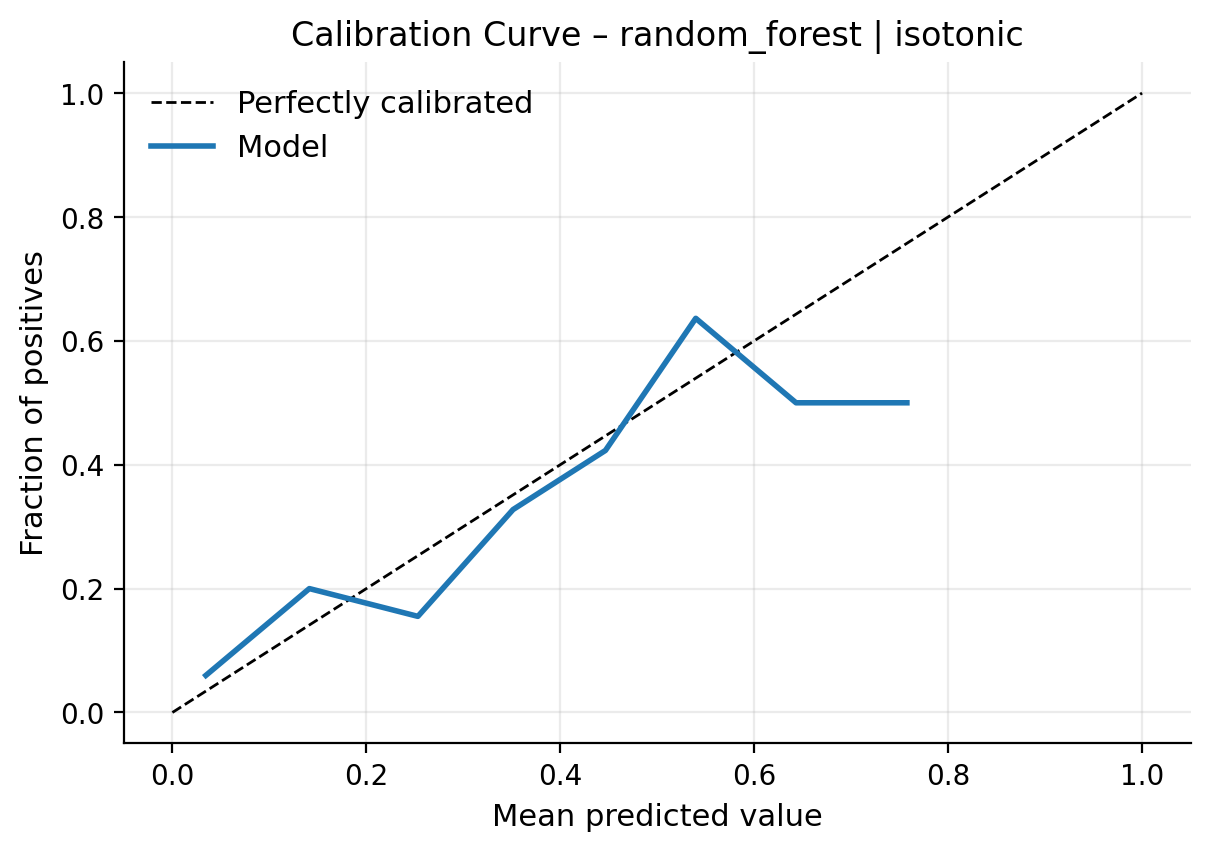

In [6]:
# %% [show figures]
def _pick(names):
    # 优先 isotonic 版本
    iso = [p for p in names if "isotonic" in p.name]
    return iso[0] if iso else (names[0] if names else None)

cands_roc = sorted(FIG_DIR.glob(f"roc_test_{MODEL}*.png"))
cands_pr  = sorted(FIG_DIR.glob(f"pr_test_{MODEL}*.png"))
cands_cal = sorted(FIG_DIR.glob(f"calibration_test_{MODEL}*.png"))

p_roc = _pick(cands_roc)
p_pr  = _pick(cands_pr)
p_cal = _pick(cands_cal)

for title, p in [("ROC", p_roc), ("PR", p_pr), ("Calibration", p_cal)]:
    if p and p.exists():
        print(f"[fig] {title}: {p}")
        display(Image(filename=str(p)))
    else:
        warnings.warn(f"未找到 {title} 图：{p}")

## 4. 阈值扫描摘要（Youden / F1 / 目标敏感度/特异度）
读取 `threshold_scan_{model}*.json` 的摘要与扫描表，打印推荐阈值并可视化落点（若图像存在）。

[ok] threshold summary:


,grid_min,grid_max,step,n,prevalence,youden_thr,f1_thr,sens_targets,spec_targets
0,0.01,0.99,0.001,981,0.215481,0.292743,0.292,"[[0.9, 0.01]]","[[0.8, 0.33299999999999974]]"


[ok] threshold grid loaded: (981, 12)


,thr,sensitivity,specificity,precision,npv,accuracy,f1,brier,tp,fp,tn,fn
0,0.010,0.961165,0.141333,0.235154,0.929825,0.317992,0.377863,0.14716,99,322,53,4
1,0.011,0.961165,0.157333,0.238554,0.936508,0.330544,0.382239,0.14716,99,316,59,4
2,0.012,0.961165,0.157333,0.238554,0.936508,0.330544,0.382239,0.14716,99,316,59,4
3,0.013,0.961165,0.157333,0.238554,0.936508,0.330544,0.382239,0.14716,99,316,59,4
4,0.014,0.961165,0.157333,0.238554,0.936508,0.330544,0.382239,0.14716,99,316,59,4


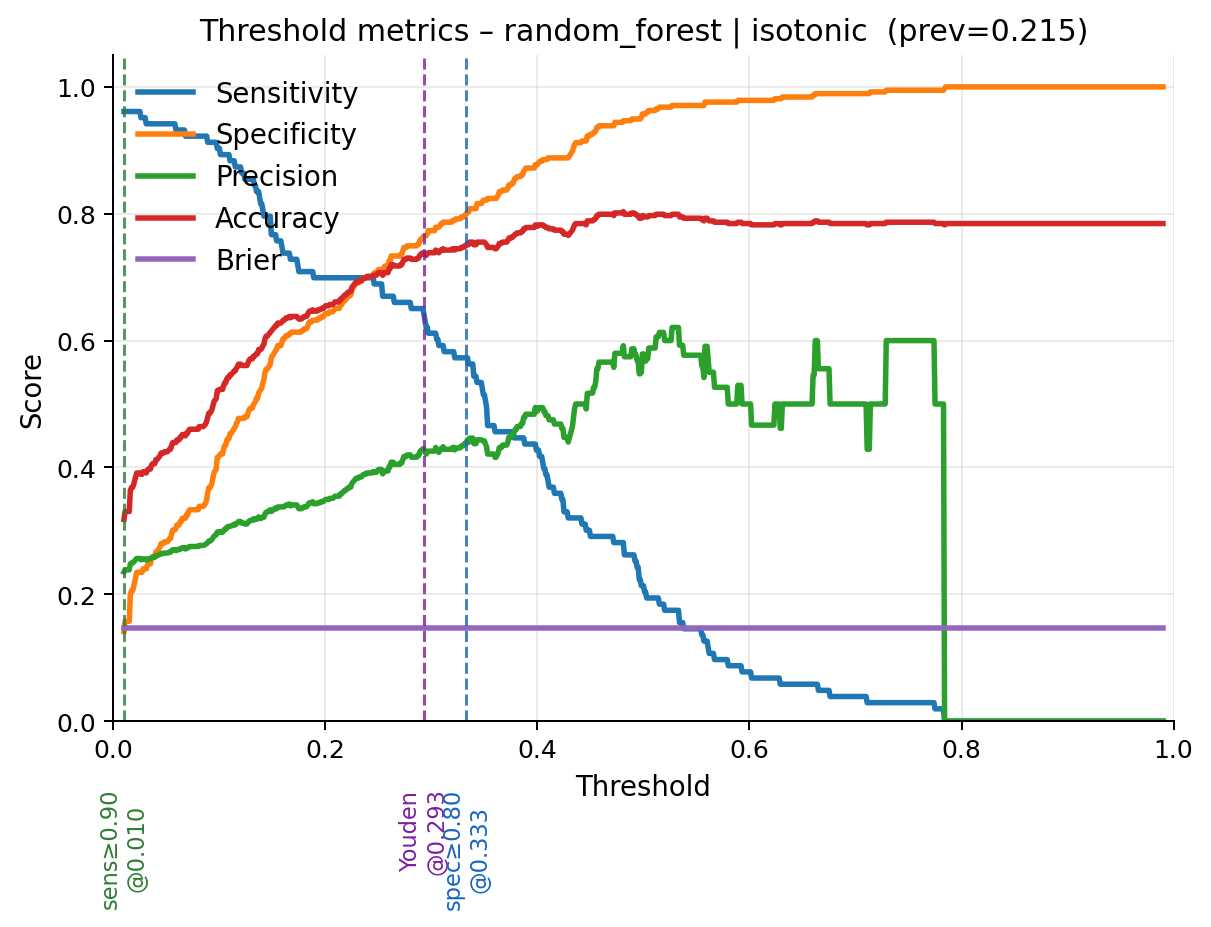

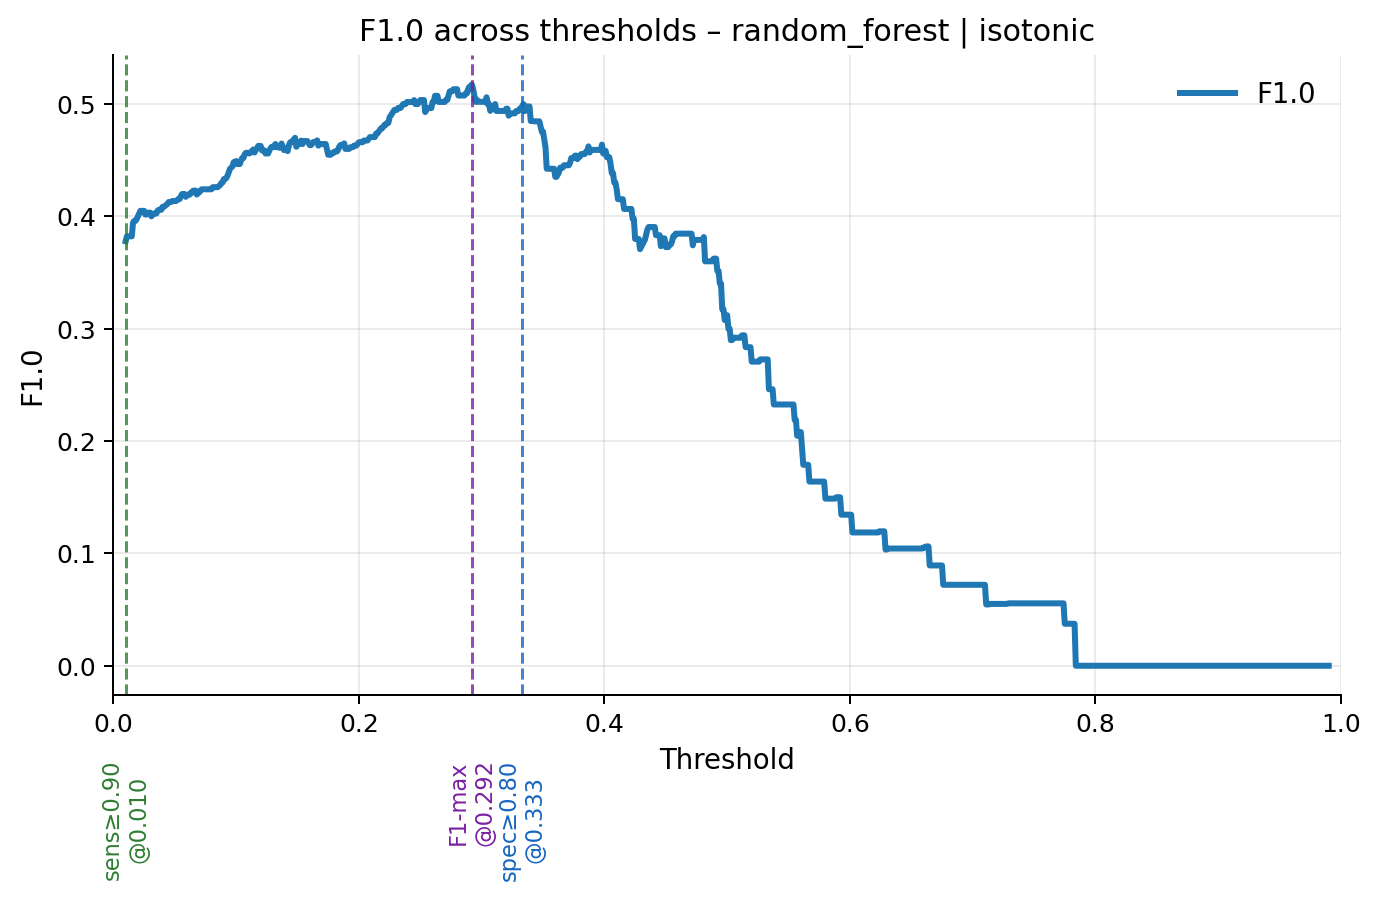

In [7]:
# %% [threshold summary]
thr_json = list((OUT_DIR).glob(f"threshold_scan_{MODEL}_*.json")) + list((OUT_DIR).glob(f"threshold_scan_*_{MODEL}_*.json"))
thr_csv  = list((OUT_DIR).glob(f"threshold_scan_{MODEL}_*.csv")) + list((OUT_DIR).glob(f"threshold_scan_*_{MODEL}_*.csv"))
p_thrj = sorted(thr_json)[-1] if thr_json else None
p_thrc = sorted(thr_csv)[-1] if thr_csv else None

if p_thrj and p_thrj.exists():
    js = json.loads(p_thrj.read_text(encoding="utf-8"))
    print("[ok] threshold summary:")
    display(pd.DataFrame([js]))
else:
    warnings.warn("未找到 threshold summary json。")

if p_thrc and p_thrc.exists():
    thr_df = pd.read_csv(p_thrc)
    print(f"[ok] threshold grid loaded: {thr_df.shape}")
    display(thr_df.head())
else:
    warnings.warn("未找到 threshold scan csv。")

# 展示我们之前输出的曲线图（若存在改名规则，则适配）
for pat in [f"thr_metrics_{MODEL}*.png", f"thr_fscore_{MODEL}*.png"]:
    cands = sorted(FIG_DIR.glob(pat)) + sorted(OUT_DIR.glob(pat))
    if cands:
        display(Image(filename=str(cands[-1])))
    else:
        warnings.warn(f"未找到图: {pat}")

## 5. 小结
- 若需更换模型：在“imports & paths”单元里把 `MODEL` 变量改为 `lightgbm/xgboost/...`（前提：已训练并落盘对应输出）
- 若需复跑：在“可选：一键复跑”单元把 `RUN_*` 开关改为 `True` 并运行
- 本 Notebook 不写入新工件，只做汇总展示与轻量分析